In [1]:
import nibabel as nib
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

In [2]:
import os
import nibabel as nib
import matplotlib.pyplot as plt

# 폴더 경로 설정
base_path = "/workspace/eli"
folders = {
    "train": "01_training",
    "val": "02_validation",
    "test": "03_test"
}

# 다양한 파일 이름 패턴 목록 (이미지와 마스크 파일 분리)
possible_image_patterns = [
    "{patient_number}_CT-ax.nii.gz",
    "{patient_number}.nii.gz",
    "{patient_number}_CT-iso.nii.gz"
]

possible_mask_patterns = [
    "{patient_number}_CT-ax_seg.nii.gz",
    "{patient_number}_seg.nii.gz",
    "{patient_number}_CT-iso_seg.nii.gz"
]

# 각 폴더에서 환자 데이터를 불러오는 함수
def load_nii_files(data_type):
    image_arrays = []
    mask_arrays = []
    
    folder_path = os.path.join(base_path, folders[data_type])
    
    # 환자 번호 폴더 목록 가져오기
    patients_numbers = os.listdir(folder_path)
    
    for patient_number in patients_numbers:
        image_path = None
        mask_path = None
        
        # 이미지 파일 경로 찾기
        for img_pattern in possible_image_patterns:
            temp_image_path = os.path.join(folder_path, patient_number, img_pattern.format(patient_number=patient_number))
            
            if os.path.exists(temp_image_path):
                image_path = temp_image_path
                break
        
        # 마스크 파일 경로 찾기
        for mask_pattern in possible_mask_patterns:
            temp_mask_path = os.path.join(folder_path, patient_number, mask_pattern.format(patient_number=patient_number))
            
            if os.path.exists(temp_mask_path):
                mask_path = temp_mask_path
                break
        
        # 경로 출력 및 Nii 파일 로드
        if image_path and mask_path:
            print(f"Loading image: {image_path}")
            print(f"Loading mask: {mask_path}")
            
            image = nib.load(image_path).get_fdata()
            mask = nib.load(mask_path).get_fdata()
            
            image_arrays.append(image)
            mask_arrays.append(mask)
        else:
            print(f"Warning: Missing files for patient {patient_number}")
    
    return image_arrays, mask_arrays

# 트레이닝, 검증, 테스트 데이터 불러오기
train_image_array, train_mask_array = load_nii_files("train")
val_image_array, val_mask_array = load_nii_files("val")
test_image_array, test_mask_array = load_nii_files("test")

Loading image: /workspace/eli/01_training/verse825/verse825_CT-iso.nii.gz
Loading mask: /workspace/eli/01_training/verse825/verse825_CT-iso_seg.nii.gz
Loading image: /workspace/eli/01_training/verse091/verse091.nii.gz
Loading mask: /workspace/eli/01_training/verse091/verse091_seg.nii.gz
Loading image: /workspace/eli/01_training/verse097/verse097.nii.gz
Loading mask: /workspace/eli/01_training/verse097/verse097_seg.nii.gz
Loading image: /workspace/eli/01_training/verse586/verse586_CT-iso.nii.gz
Loading mask: /workspace/eli/01_training/verse586/verse586_CT-iso_seg.nii.gz
Loading image: /workspace/eli/01_training/GL003/GL003.nii.gz
Loading mask: /workspace/eli/01_training/GL003/GL003_seg.nii.gz
Loading image: /workspace/eli/01_training/verse539/verse539_CT-iso.nii.gz
Loading mask: /workspace/eli/01_training/verse539/verse539_CT-iso_seg.nii.gz
Loading image: /workspace/eli/01_training/verse544/verse544.nii.gz
Loading mask: /workspace/eli/01_training/verse544/verse544_seg.nii.gz
Loading ima

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class MedicalDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # 필요시 numpy 배열을 tensor로 변환하고 차원 추가 (1, Depth, Height, Width)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # (1, Depth, Height, Width)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)    # (1, Depth, Height, Width)

        # 이미지와 마스크를 64x64x64로 리사이즈 (3D interpolate 사용)
        image = F.interpolate(image.unsqueeze(0), size=(64, 64, 64), mode='trilinear', align_corners=True).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0), size=(64, 64, 64), mode='trilinear', align_corners=True).squeeze(0)

        return image, mask

# 데이터셋 생성
train_dataset = MedicalDataset(train_image_array, train_mask_array)
val_dataset = MedicalDataset(val_image_array, val_mask_array)
test_dataset = MedicalDataset(test_image_array, test_mask_array)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 확인용 출력
for images, masks in train_loader:
    print("Image shape:", images.shape)
    print("Mask shape:", masks.shape)
    break  # 첫 배치만 확인

Image shape: torch.Size([1, 1, 64, 64, 64])
Mask shape: torch.Size([1, 1, 64, 64, 64])


In [4]:
import torch
import torch.nn as nn

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        # Encoder
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = self.upconv_block(1024, 512)
        self.decoder4 = self.conv_block(1024, 512)

        self.upconv3 = self.upconv_block(512, 256)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = self.upconv_block(256, 128)
        self.decoder2 = self.conv_block(256, 128)

        self.upconv1 = self.upconv_block(128, 64)
        self.decoder1 = self.conv_block(128, 64)

        # Final convolution to get the desired output channels
        self.final_conv = nn.Conv3d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(nn.MaxPool3d(2)(enc1))
        enc3 = self.encoder3(nn.MaxPool3d(2)(enc2))
        enc4 = self.encoder4(nn.MaxPool3d(2)(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool3d(2)(enc4))

        # Decoding path with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)  # Concatenate along channel axis
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        # Final 1x1 convolution to get the output
        return self.final_conv(dec1)

# Model initialization with desired input and output channels
model = UNet3D(in_channels=1, out_channels=1)  # Example: single channel input and output

/tmp/ipykernel_2565194/902545643.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./unet3d_best_epoch.pth'))


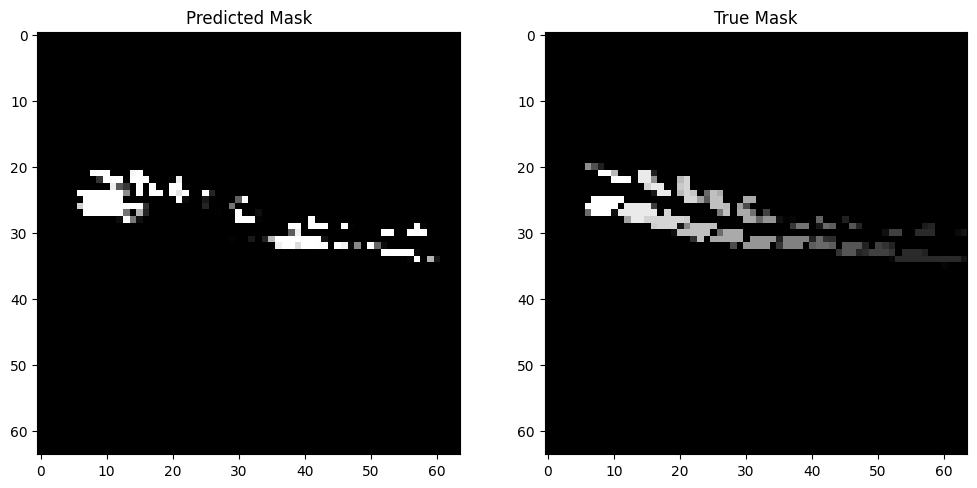

Test Loss: 0.5518502037739381
Test IoU: 4.021383263519965
Test Accuracy: 0.9847632050514221


In [5]:
# 저장된 가중치 불러오기
model = UNet3D(in_channels=1, out_channels=1)
model.load_state_dict(torch.load('./unet3d_best_epoch.pth'))
model.eval()  # 모델을 평가 모드로 전환

# 손실 함수 정의 (예시: binary cross entropy loss 사용)
criterion = torch.nn.BCEWithLogitsLoss()

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# IoU 계산 함수
def calculate_iou(pred_mask, true_mask, threshold=0.5):
    pred_mask_bin = (pred_mask > threshold).float()  # Threshold 적용하여 이진화
    intersection = torch.sum(pred_mask_bin * true_mask)
    union = torch.sum(pred_mask_bin) + torch.sum(true_mask) - intersection
    iou = intersection / union
    return iou.item()

# 정확도 계산 함수
def calculate_accuracy(pred_mask, true_mask, threshold=0.5):
    pred_mask_bin = (pred_mask > threshold).float()  # Threshold 적용하여 이진화
    correct = torch.sum(pred_mask_bin == true_mask)
    total = torch.numel(true_mask)
    accuracy = correct / total
    return accuracy.item()

# 테스트 데이터셋에 대한 예측 수행 및 IoU, Loss, Accuracy 계산
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

total_loss = 0
total_iou = 0
total_accuracy = 0

with torch.no_grad():  # 예측 중에는 gradient 계산을 하지 않음
    for idx, (image, true_mask) in enumerate(test_loader):
        image = image.to(device)
        true_mask = true_mask.to(device)

        # 예측 마스크 계산
        pred_mask = model(image)
        pred_mask = torch.sigmoid(pred_mask)  # 출력 값을 [0, 1]로 스케일링

        # 손실 계산
        loss = criterion(pred_mask, true_mask)
        total_loss += loss.item()

        # IoU 계산
        iou = calculate_iou(pred_mask, true_mask)
        total_iou += iou

        # 정확도 계산
        accuracy = calculate_accuracy(pred_mask, true_mask)
        total_accuracy += accuracy

        # 결과 시각화 (첫 번째 테스트 샘플만 예시로 출력)
        if idx == 0:
            pred_mask_np = pred_mask.cpu().numpy().squeeze()
            true_mask_np = true_mask.cpu().numpy().squeeze()

            # 결과 시각화
            slice_idx = pred_mask_np.shape[0] // 2  # 가운데 슬라이스 선택

            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Predicted Mask")
            plt.imshow(pred_mask_np[slice_idx], cmap='gray')

            plt.subplot(1, 2, 2)
            plt.title("True Mask")
            plt.imshow(true_mask_np[slice_idx], cmap='gray')

            plt.show()

# 평균 Loss, IoU, Accuracy 출력
num_samples = len(test_loader)
average_loss = total_loss / num_samples
average_iou = total_iou / num_samples
average_accuracy = total_accuracy / num_samples

print(f"Test Loss: {average_loss}")
print(f"Test IoU: {average_iou}")
print(f"Test Accuracy: {average_accuracy}")


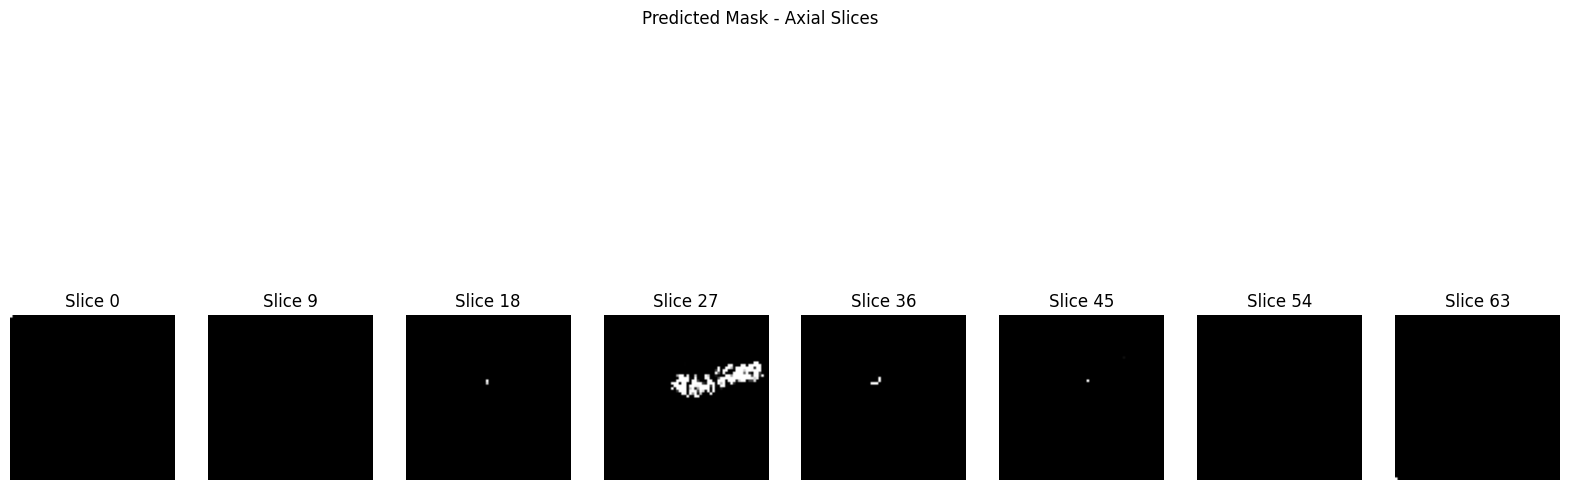

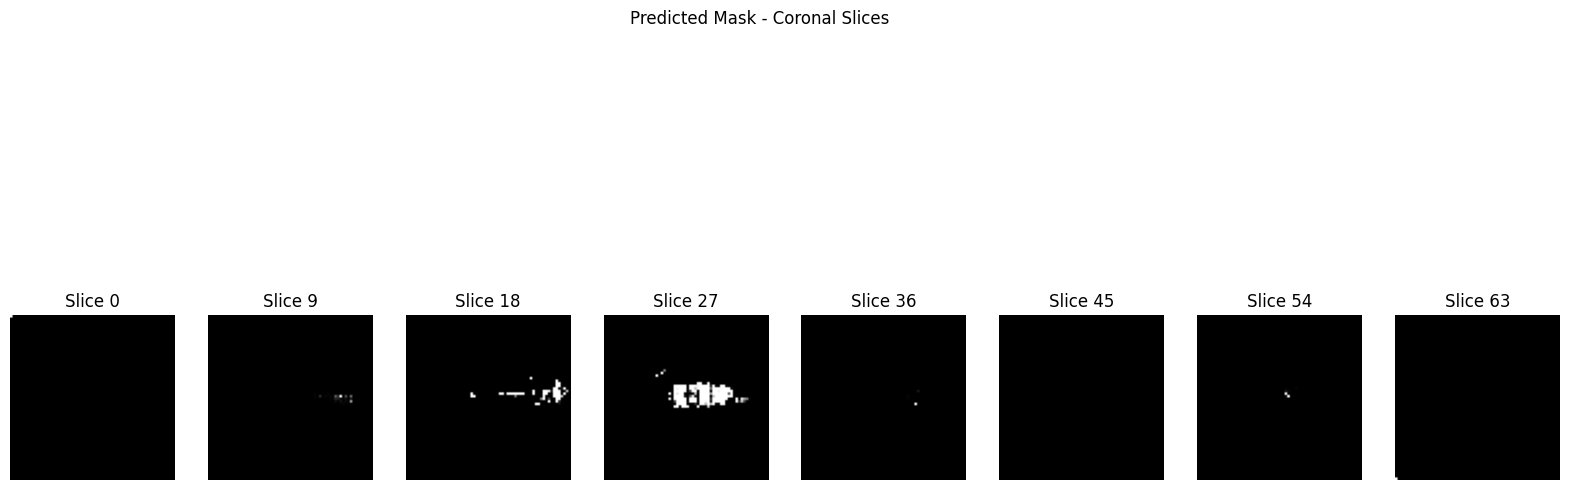

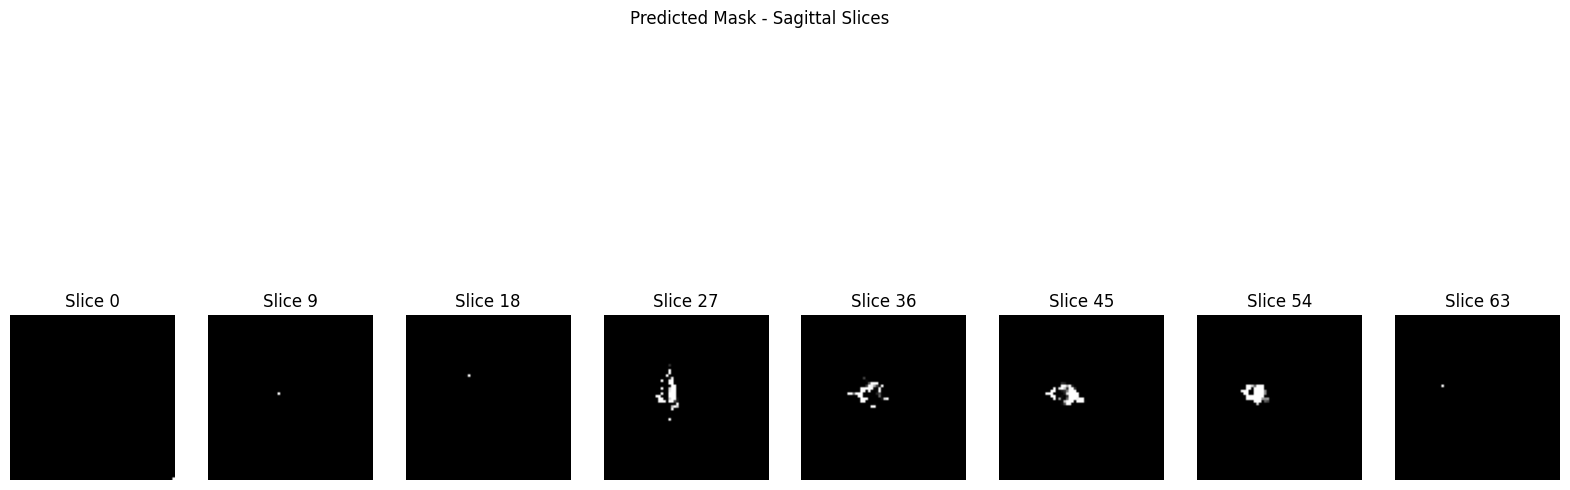

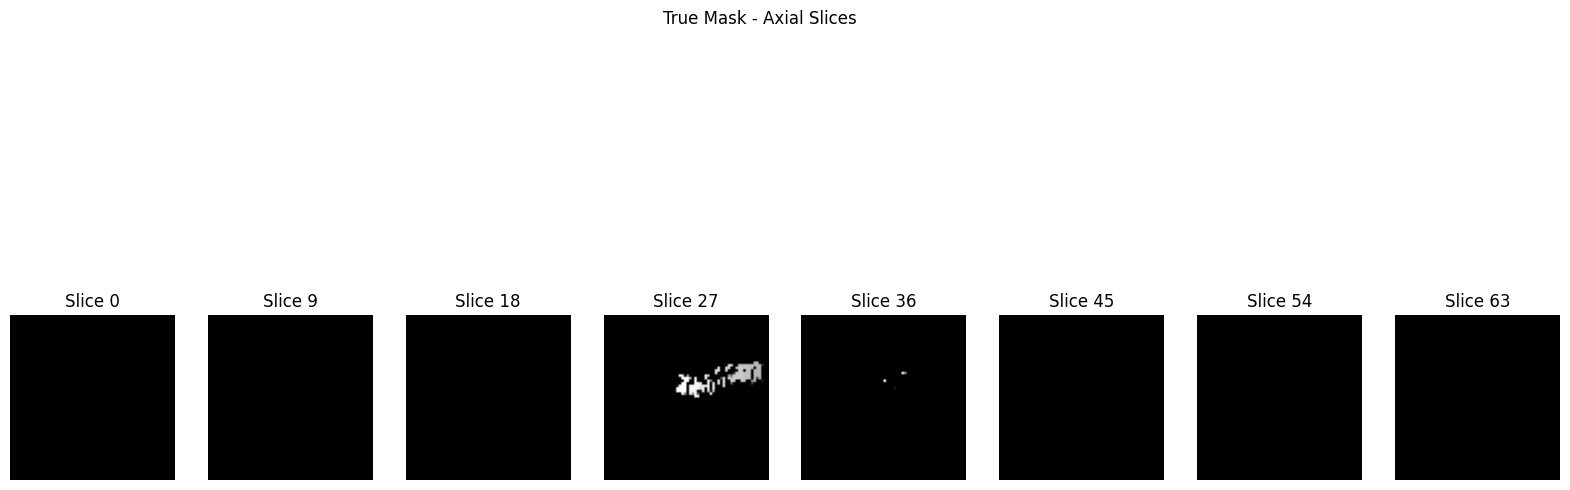

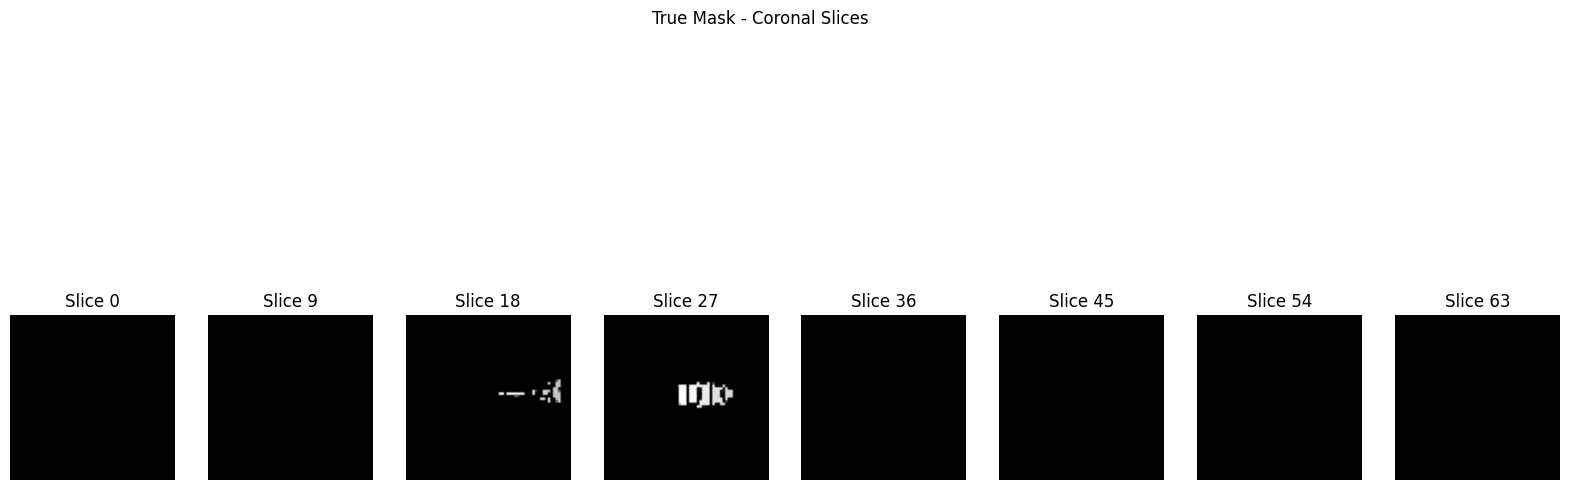

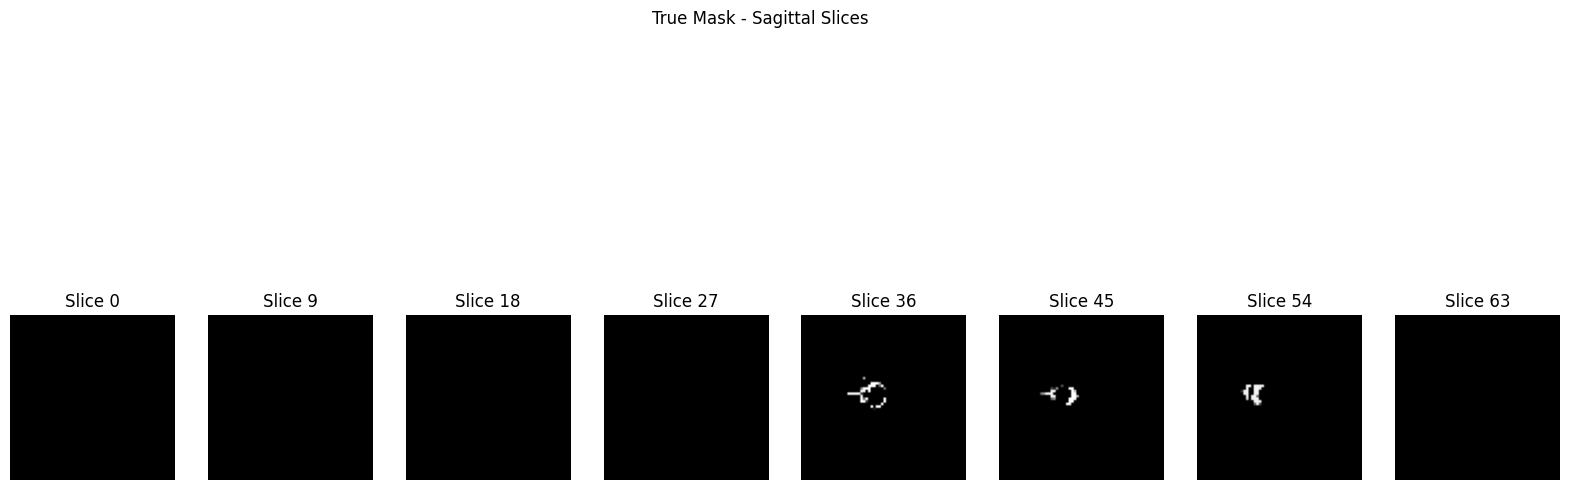

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_3d_slices(volume, n_slices=8, axis=0, title="Volume Slices"):
    """
    volume: 3D numpy array
    n_slices: Number of slices to display
    axis: Axis along which to slice (0: Axial, 1: Coronal, 2: Sagittal)
    """
    # 슬라이스 축을 기준으로 3D 볼륨 슬라이스
    slices = np.linspace(0, volume.shape[axis] - 1, n_slices).astype(int)

    plt.figure(figsize=(20, 8))
    for i, slice_idx in enumerate(slices):
        plt.subplot(1, n_slices, i + 1)
        if axis == 0:  # Axial
            plt.imshow(volume[slice_idx, :, :], cmap='gray')
        elif axis == 1:  # Coronal
            plt.imshow(volume[:, slice_idx, :], cmap='gray')
        elif axis == 2:  # Sagittal
            plt.imshow(volume[:, :, slice_idx], cmap='gray')

        plt.axis('off')
        plt.title(f'Slice {slice_idx}')
    plt.suptitle(title)
    plt.show()

# 예측 마스크 시각화
pred_mask_np = pred_mask.cpu().numpy().squeeze()  # 3D numpy array로 변환
true_mask_np = true_mask.cpu().numpy().squeeze()  # 3D numpy array로 변환

# 예측 마스크 3D 슬라이스 시각화
plot_3d_slices(pred_mask_np, n_slices=8, axis=0, title="Predicted Mask - Axial Slices")
plot_3d_slices(pred_mask_np, n_slices=8, axis=1, title="Predicted Mask - Coronal Slices")
plot_3d_slices(pred_mask_np, n_slices=8, axis=2, title="Predicted Mask - Sagittal Slices")

# 실제 마스크 3D 슬라이스 시각화
plot_3d_slices(true_mask_np, n_slices=8, axis=0, title="True Mask - Axial Slices")
plot_3d_slices(true_mask_np, n_slices=8, axis=1, title="True Mask - Coronal Slices")
plot_3d_slices(true_mask_np, n_slices=8, axis=2, title="True Mask - Sagittal Slices")
